In [142]:
import numpy as np
import pandas as pd
from sklearn import  linear_model, metrics, preprocessing
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, KFold
from sklearn import pipeline

In [143]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


### Загрузка данных

In [144]:
raw_data = pd.read_csv('bike_sharing_demand.csv', header = 0, sep = ',')
raw_data

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0000,3,13,16
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0000,8,32,40
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0000,5,27,32
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0000,3,10,13
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0000,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...
10881,2012-12-19 19:00:00,4,0,1,1,15.58,19.695,50,26.0027,7,329,336
10882,2012-12-19 20:00:00,4,0,1,1,14.76,17.425,57,15.0013,10,231,241
10883,2012-12-19 21:00:00,4,0,1,1,13.94,15.910,61,15.0013,4,164,168
10884,2012-12-19 22:00:00,4,0,1,1,13.94,17.425,61,6.0032,12,117,129


In [145]:
raw_data['datetime'] = pd.to_datetime(raw_data['datetime'])

raw_data['month'] = raw_data['datetime'].apply(lambda x: x.month)
raw_data['hour'] = raw_data['datetime'].apply(lambda x: x.hour)

raw_data = raw_data.drop(['datetime', 'registered', 'casual'], axis=1)

In [146]:
train_label = raw_data['count'][:-1000:]
test_label = raw_data['count'][-1000:]

train_data = raw_data.drop(['count'], axis=1)[:-1000]
test_data = raw_data.drop(['count'], axis=1)[-1000:]

In [147]:
train_data

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,month,hour
0,1,0,0,1,9.84,14.395,81,0.0000,1,0
1,1,0,0,1,9.02,13.635,80,0.0000,1,1
2,1,0,0,1,9.02,13.635,80,0.0000,1,2
3,1,0,0,1,9.84,14.395,75,0.0000,1,3
4,1,0,0,1,9.84,14.395,75,0.0000,1,4
...,...,...,...,...,...,...,...,...,...,...
9881,4,0,1,1,18.04,21.970,67,8.9981,10,2
9882,4,0,1,1,17.22,21.210,67,7.0015,10,3
9883,4,0,1,1,17.22,21.210,67,11.0014,10,4
9884,4,0,1,1,17.22,21.210,67,16.9979,10,5


In [148]:
binary_columns = ['workingday', 'holiday']
binary_indicates = [(column in binary_columns) for column in train_data.columns]

print(binary_indicates)

[False, True, True, False, False, False, False, False, False, False]


In [149]:
numeric_columns = ['temp', 'atemp', 'humidity', 'windspeed', 'hour']
numeric_indicates = [(column in numeric_columns) for column in train_data.columns]

print(numeric_indicates)

[False, False, False, False, True, True, True, True, False, True]


In [150]:
categorial_columns = ['season', 'weather', 'month'] 
categorial_indicates = np.array([(column in categorial_columns) for column in train_data],dtype=bool)

print(categorial_indicates)

[ True False False  True False False False False  True False]


In [151]:
regressor = linear_model.SGDRegressor(random_state = 0, loss = 'squared_loss', penalty = 'l2')

In [152]:
pipe = pipeline.Pipeline(steps = [ 
    ('feature_processing', pipeline.FeatureUnion(transformer_list=[
        #binary
        ('binary_variables_processing', preprocessing.FunctionTransformer(lambda x: x[:,binary_indicates], validate=True)),
        
        #numeric
        ('numeric_variables_processing', pipeline.Pipeline(steps=[
            ('selecting', preprocessing.FunctionTransformer(lambda x: x[:,numeric_indicates], validate=True)),
            ('scaling', preprocessing.StandardScaler())
        ])),
        
        #categorial
        ('categorical_variables_processing', pipeline.Pipeline(steps=[
            ('selecting', preprocessing.FunctionTransformer(lambda x: x[:, categorial_indicates], validate=True)),
            ('hot_encoding', preprocessing.OneHotEncoder(handle_unknown = 'ignore'))
        ]))
    ])),
    ('model_fitting', regressor)
])

In [153]:
pipe.fit(train_data, train_label)

Pipeline(steps=[('feature_processing',
                 FeatureUnion(transformer_list=[('binary_variables_processing',
                                                 FunctionTransformer(func=<function <lambda> at 0x000002ABC6A55DC0>,
                                                                     validate=True)),
                                                ('numeric_variables_processing',
                                                 Pipeline(steps=[('selecting',
                                                                  FunctionTransformer(func=<function <lambda> at 0x000002ABC69DCF70>,
                                                                                      validate=True)),
                                                                 ('scaling',
                                                                  StandardScaler())])),
                                                ('categorical_variables_processing',
                               

In [154]:
print('MAE:', metrics.mean_absolute_error(test_label, pipe.predict(test_data)))
print('MSE:', metrics.mean_squared_error(test_label, pipe.predict(test_data)))

MAE: 121.53617393811888
MSE: 32220.214760127135


In [155]:
parameters_grid = {
    'model_fitting__alpha' : [0.0001, 0.001, 0,1],
    'model_fitting__eta0' : [0.001, 0.05],
}

In [156]:
grid_cv = GridSearchCV(pipe, parameters_grid, scoring = 'neg_mean_absolute_error', cv = 4)

In [157]:
grid_cv.fit(train_data, train_label)

GridSearchCV(cv=4,
             estimator=Pipeline(steps=[('feature_processing',
                                        FeatureUnion(transformer_list=[('binary_variables_processing',
                                                                        FunctionTransformer(func=<function <lambda> at 0x000002ABC6A55DC0>,
                                                                                            validate=True)),
                                                                       ('numeric_variables_processing',
                                                                        Pipeline(steps=[('selecting',
                                                                                         FunctionTransformer(func=<function <lambda> at 0x000002ABC69DCF70>,
                                                                                                             validate=True)),
                                                                              

In [158]:
grid_cv.best_estimator_

Pipeline(steps=[('feature_processing',
                 FeatureUnion(transformer_list=[('binary_variables_processing',
                                                 FunctionTransformer(func=<function <lambda> at 0x000002ABC6A55DC0>,
                                                                     validate=True)),
                                                ('numeric_variables_processing',
                                                 Pipeline(steps=[('selecting',
                                                                  FunctionTransformer(func=<function <lambda> at 0x000002ABC69DCF70>,
                                                                                      validate=True)),
                                                                 ('scaling',
                                                                  StandardScaler())])),
                                                ('categorical_variables_processing',
                               

In [159]:
print(grid_cv.best_score_)
print(grid_cv.best_params_)

-117.70676317370567
{'model_fitting__alpha': 0.001, 'model_fitting__eta0': 0.001}


In [160]:
metrics.mean_absolute_error(test_label,grid_cv.best_estimator_.predict(test_data))

121.77509634275438

In [161]:
print(test_label[:10].values)


[525 835 355 222 228 325 328 308 346 446]


In [162]:
grid_cv.best_estimator_.predict(test_data[:10])

array([157.46868391, 182.52527484, 222.99609297, 253.43042485,
       268.15805624, 287.86445301, 289.0674253 , 316.81885752,
       320.21956388, 331.17916267])

Text(0, 0.5, 'predicted')

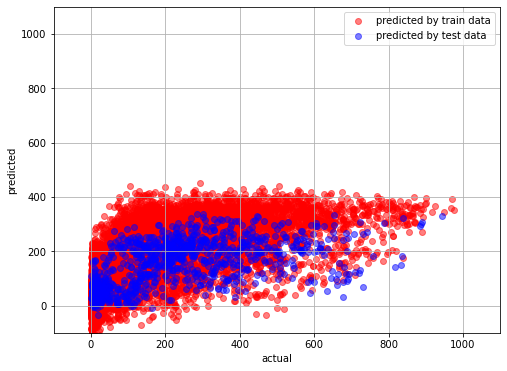

In [164]:
pylab.figure(figsize=(8, 6))
pylab.grid(True)
pylab.xlim(-100,1100)
pylab.ylim(-100,1100)
pylab.scatter(train_label, grid_cv.best_estimator_.predict(train_data), alpha=0.5, color = 'red', label='predicted by train data')
pylab.scatter(test_label, grid_cv.best_estimator_.predict(test_data), alpha=0.5, color = 'blue', label='predicted by test data')
pylab.legend()
pylab.xlabel('actual')
pylab.ylabel('predicted')

In [165]:
from sklearn.ensemble import RandomForestRegressor

In [166]:
regressor = RandomForestRegressor(random_state=0, max_depth=20, n_estimators = 50)

In [167]:
pipe = pipeline.Pipeline(steps = [
    ('feature_processing', pipeline.FeatureUnion(transformer_list=[
#         binary
        ('preprocessing binary', preprocessing.FunctionTransformer(lambda x: x[:,binary_indicates], validate=True)),
        
#         categorial
        ('preprocessing categorial', pipeline.Pipeline(steps=[
            ('secelting',preprocessing.FunctionTransformer(lambda x: x[:,categorial_indicates], validate=True)),
            ('encoding', preprocessing.OneHotEncoder(handle_unknown = 'ignore'))
        ])),
        
#         numeric
        ('preprocessing numeric', pipeline.Pipeline(steps=[
            ('selecting', preprocessing.FunctionTransformer(lambda x: x[:, numeric_indicates], validate=True)),
            ('scaling', preprocessing.StandardScaler())
        ]))
    ]
    )),
    ('fitting model',regressor)
])

In [168]:
pipe.fit(train_data, train_label)

Pipeline(steps=[('feature_processing',
                 FeatureUnion(transformer_list=[('preprocessing binary',
                                                 FunctionTransformer(func=<function <lambda> at 0x000002ABD012CD30>,
                                                                     validate=True)),
                                                ('preprocessing categorial',
                                                 Pipeline(steps=[('secelting',
                                                                  FunctionTransformer(func=<function <lambda> at 0x000002ABD012CDC0>,
                                                                                      validate=True)),
                                                                 ('encoding',
                                                                  OneHotEncoder(handle_unknown='ignore'))])),
                                                ('preprocessing numeric',
                              

In [169]:
grid_cv_1 = GridSearchCV(pipe, parameters_grid, scoring = 'neg_mean_absolute_error', cv = 4)


In [170]:
parameters_grid = {'ccp_alpha':[0,0.5,1]}

In [171]:
grid_cv_1.fit(train_data, train_label)

ValueError: Invalid parameter model_fitting for estimator Pipeline(steps=[('feature_processing',
                 FeatureUnion(transformer_list=[('preprocessing binary',
                                                 FunctionTransformer(func=<function <lambda> at 0x000002ABD012CD30>,
                                                                     validate=True)),
                                                ('preprocessing categorial',
                                                 Pipeline(steps=[('secelting',
                                                                  FunctionTransformer(func=<function <lambda> at 0x000002ABD012CDC0>,
                                                                                      validate=True)),
                                                                 ('encoding',
                                                                  OneHotEncoder(handle_unknown='ignore'))])),
                                                ('preprocessing numeric',
                                                 Pipeline(steps=[('selecting',
                                                                  FunctionTransformer(func=<function <lambda> at 0x000002ABD012CEE0>,
                                                                                      validate=True)),
                                                                 ('scaling',
                                                                  StandardScaler())]))])),
                ('fitting model',
                 RandomForestRegressor(max_depth=20, n_estimators=50,
                                       random_state=0))]). Check the list of available parameters with `estimator.get_params().keys()`.

In [172]:
metrics.mean_absolute_error(test_label, pipe.predict(test_data))

79.4628942518859

In [173]:
pipe.predict(test_data[:10])

array([392.83833333, 494.62      , 253.13666667, 164.77159524,
       207.54974784, 265.17746153, 261.3199677 , 317.14774486,
       279.94582311, 431.69      ])

In [174]:
test_label[:10]

9886    525
9887    835
9888    355
9889    222
9890    228
9891    325
9892    328
9893    308
9894    346
9895    446
Name: count, dtype: int64

In [175]:
parameters_grid

{'ccp_alpha': [0, 0.5, 1]}

In [176]:
parameters_grid = {'fitting model__bootstrap':[2,6,10]}

In [177]:
grid_cv_1.best_estimator_.predict(test_data[:10])

AttributeError: 'GridSearchCV' object has no attribute 'best_estimator_'

Text(0.5, 1.0, 'random forest model')

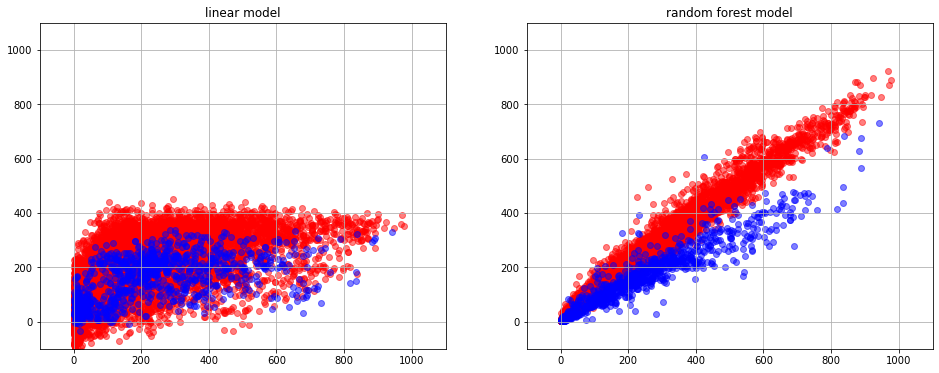

In [178]:
pylab.figure(figsize=(16, 6))

pylab.subplot(1,2,1)
pylab.grid(True)
pylab.xlim(-100,1100)
pylab.ylim(-100,1100)
pylab.scatter(train_label, grid_cv.best_estimator_.predict(train_data), alpha=0.5, color = 'red')
pylab.scatter(test_label, grid_cv.best_estimator_.predict(test_data), alpha=0.5, color = 'blue')
pylab.title('linear model')

pylab.subplot(1,2,2)
pylab.grid(True)
pylab.xlim(-100,1100)
pylab.ylim(-100,1100)
pylab.scatter(train_label, pipe.predict(train_data), alpha=0.5, color = 'red')
pylab.scatter(test_label, pipe.predict(test_data), alpha=0.5, color = 'blue')
pylab.title('random forest model')